In [17]:
import pandas as pd
import numpy as np

import plotly.express as px

import yaml

In [18]:
distances = pd.read_excel("../../data/ExtendedNuclearData.xlsx", sheet_name="Transport")

In [19]:
distances_dict = dict()
for idx, row in distances[distances["is_possible"] != 0].iterrows():
    org = row["from"]
    dest = row["to"]

    dist = row["costs"]

    if org in distances_dict.keys():
        relations_from_org = distances_dict[org]
        relations_from_org[dest] = dist
    else:
        relations_from_org = dict()
        relations_from_org[dest] = dist
        distances_dict[org] = relations_from_org

In [23]:
with open('C:/Users/ACER/Desktop/Uni/9_WiSe_23_24/OR-INF/operations_oppenheimer/operations_oppenheimer/src/parameter_config.yaml', 'r') as file:
    config_data = yaml.safe_load(file)

In [24]:
transport_costs_per_km = config_data["transport_costs"]["cost_factor"]
transport_factor = config_data["transport_costs"]["nuclear_factor"]

In [63]:
transport_factor

100

In [25]:
construction_costs = config_data["cisf"]["versions"]
versions = dict()

for cisf_dict in construction_costs:
    k = cisf_dict["size"]
    v = cisf_dict["costs"]
    versions[k] = v

In [26]:
snf = pd.read_csv("../../storage/n_hc_nothing/n_cisf_nothing/snf_shipped.csv")
nc = pd.read_csv("../../storage/n_hc_nothing/n_cisf_nothing/nc_shipped.csv")
cisf = pd.read_csv("../../storage/n_hc_nothing/n_cisf_nothing/cisf_build.csv")
hc = pd.read_csv("../../storage/n_hc_nothing/n_cisf_nothing/hc_build.csv")

##### Transport costs

In [80]:
def get_transport_costs(snf: pd.DataFrame, nc: pd.DataFrame, distances: pd.DataFrame, transport_factor) -> float:
    snf_shipped = snf[snf["SNF"] != 0]
    nc_shipped = nc[nc["NC"] != 0]

    shipped = pd.concat([snf_shipped.rename(columns={"SNF": "amount"}), nc_shipped.rename(columns={"NC": "amount"})])

    distances["key"] = distances["from"] + distances["to"]
    shipped["key"] = shipped["from"] + shipped["to"]

    shipped = pd.merge(left=shipped, left_on="key", right=distances.drop(columns=["from", "to", "is_possible"]), right_on="key", how="left").drop(columns="key")
    shipped["transport_costs"] = shipped["costs"] * shipped["amount"] * transport_costs_per_km * transport_factor

    return np.sum(shipped["transport_costs"])

In [66]:
get_transport_costs(snf, nc, distances, transport_factor)

657180075.0

##### CISF costs

In [29]:
versions

{'small': 96444026.38,
 'medium': 142844431.51,
 'large': 189244836.64,
 'xlarge': 255531129.69,
 'complete': 341703310.66}

In [73]:
def get_cisf_construction_costs(cisf: pd.DataFrame, versions: dict) -> float:

    built = cisf[cisf["build"] == 1]

    versions_built = built.groupby(by="size", as_index=False).agg(n = ("build", "sum"))

    total_cisf_construction_costs = 0

    for idx, row in versions_built.iterrows():
        total_cisf_construction_costs += row["n"] * versions[row["size"]]

    return total_cisf_construction_costs

In [75]:
get_cisf_construction_costs(cisf, versions)

524977320.90999997

##### Hot Cell costs

In [69]:
def get_hot_cell_construction_costs(hc: pd.DataFrame, config_data) -> float:
    hc_construction_cost = config_data["hot_cells"]["construction_cost"]
    return sum(hc["build"]) * hc_construction_cost[0]

In [71]:
def get_hot_cell_processing_costs(nc: pd.DataFrame, config_data) -> float:
    return np.sum(nc["NC"]) * config_data["hot_cells"]["processing_cost"]

##### Plotting

In [83]:
def get_cost_df(snf, nc, distances, transport_factor, cisf, versions, hc, config_data) -> pd.DataFrame: 
    rows = []

    rows.append({
        "cost_center": "Transport",
        "amount": get_transport_costs(snf, nc, distances, transport_factor)
    })

    rows.append({
        "cost_center": "CISF construction",
        "amount": get_cisf_construction_costs(cisf, versions)
    })

    rows.append({
        "cost_center": "HC construction",
        "amount": get_hot_cell_construction_costs(hc, config_data)
    })

    rows.append({
        "cost_center": "Refilling",
        "amount": get_hot_cell_processing_costs(nc, config_data)
    })

    costs = pd.DataFrame(rows)
    costs["amount_in_billion"] = costs["amount"] / 1000000000

    return costs

In [84]:
costs = get_cost_df(snf, nc, distances, transport_factor, cisf, versions, hc, config_data)
np.sum(costs["amount_in_billion"])

6.73869762091

In [62]:
fig = px.bar(costs,
       x="cost_center",
       y="amount_in_billion",
       color="cost_center",
       template="seaborn",
       labels={"cost_center": "Cost center",
               "amount_in_billion": "Amount [Billion EUR]"},
        width=700, height=600)

fig.update_layout(showlegend=False)

fig.show()

In [38]:
import seaborn as sns

[Text(0.5, 0, ''), Text(0, 0.5, 'Amount [EUR]')]

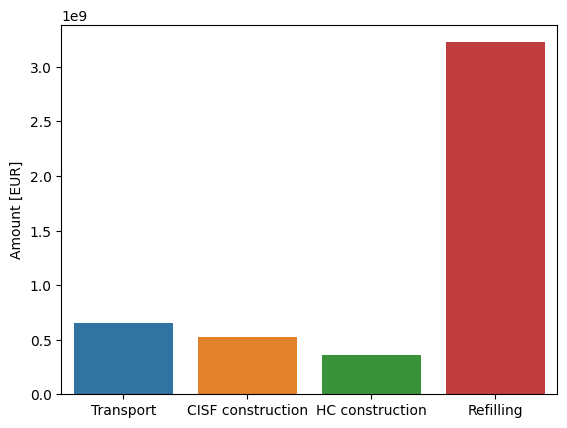

In [46]:
ax = sns.barplot(data=costs,
            x="cost_center",
            y="amount",
            hue="cost_center")
ax.set(xlabel='', ylabel='Amount [EUR]')


In [97]:
tf_sensitivity_df = pd.DataFrame()

for tf in [25, 50, 200, 400]:

    snf_sa = pd.read_csv("../../storage/n_hc_" + str(tf) + "/n_cisf_nothing/snf_shipped.csv")
    nc_sa = pd.read_csv("../../storage/n_hc_" + str(tf) + "/n_cisf_nothing/nc_shipped.csv")
    cisf_sa = pd.read_csv("../../storage/n_hc_" + str(tf) + "/n_cisf_nothing/cisf_build.csv")
    hc_sa = pd.read_csv("../../storage/n_hc_" + str(tf) + "/n_cisf_nothing/hc_build.csv")

    print(cisf_sa[cisf_sa["build"] == 1])

    costs_for_tf = get_cost_df(snf_sa, nc_sa, distances, tf, cisf_sa, versions, hc_sa, config_data)
    costs_for_tf["transport_factor"] = tf

    tf_sensitivity_df = pd.concat([tf_sensitivity_df, costs_for_tf])

tf_sensitivity_df["transport_factor"] = tf_sensitivity_df["transport_factor"].astype("str")

          cisf    size  build
146   Lüneburg  medium      1
723  Stuttgart  xlarge      1
          cisf    size  build
137    Harburg   large      1
723  Stuttgart  xlarge      1
                      cisf    size  build
130               Cuxhaven   small      1
140      Lüchow-Dannenberg   small      1
346      Rhein-Pfalz-Kreis  medium      1
480  Vorpommern-Greifswald   small      1
690                Münster   small      1
771               Schwaben  medium      1
                      cisf    size  build
100         Hameln-Pyrmont   small      1
130               Cuxhaven   small      1
140      Lüchow-Dannenberg   small      1
205    Grafschaft Bentheim   small      1
346      Rhein-Pfalz-Kreis  medium      1
480  Vorpommern-Greifswald   small      1
745           Niederbayern   small      1
765           Unterfranken   small      1
770               Schwaben   small      1


In [98]:
px.bar(data_frame=tf_sensitivity_df[tf_sensitivity_df["cost_center"] != "Refilling"],
       x="transport_factor",
       y="amount_in_billion",
       color="cost_center",
       template="seaborn",
       labels={"cost_center": "Cost center",
               "amount_in_billion": "Amount [Billion EUR]",
               "transport_factor": "Transport factor"},
        width=700, height=600)

In [101]:
rows = []

for tf in [25, 50, 200, 400]:

    cisf_sa = pd.read_csv("../../storage/n_hc_" + str(tf) + "/n_cisf_nothing/cisf_build.csv")
    hc_sa = pd.read_csv("../../storage/n_hc_" + str(tf) + "/n_cisf_nothing/hc_build.csv")

    n_cisf = sum(cisf_sa["build"])
    n_hc = sum(hc_sa["build"])

    rows.append({
        "transport_factor": str(tf),
        "n": n_cisf,
        "facility_type": "cisf" 
    })

    rows.append({
        "transport_factor": str(tf),
        "n": n_hc,
        "facility_type": "hc" 
    })

tf_construction_df = pd.DataFrame(rows)

In [102]:
px.bar(
    tf_construction_df,
    x="transport_factor",
    y="n",
    color="facility_type",
    template="seaborn"
)